In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
from tqdm import tqdm
import random
from keras.utils.np_utils import to_categorical 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
import os
from PIL import Image, ImageChops, ImageEnhance
from IPython.display import display # to display images

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path_original = '/content/drive/My Drive/training/pristine/'
path_tampered = '/content/drive/My Drive/training/fake/'

total_orig = os.listdir(path_original)
total_tampered = os.listdir(path_tampered)

In [4]:
total_tampered.remove('.DS_Store')

In [5]:
len(total_orig),len(total_tampered)

(1050, 451)

In [6]:
images = []
for file in tqdm(total_orig):  #choose all pristine
    try:
        if file.endswith('png'):
                line = path_original + file  + ',0\n'
                images.append(line)
    except:
        print(path_original+file)
        
for file in tqdm(total_tampered):       #choose all tampered images
    try:
        if file.endswith('png'):
                    line = path_tampered + file + ',1\n'
                    images.append(line)

    except:
          print(path_tampered+file)

100%|██████████| 451/451 [00:00<00:00, 175818.49it/s]


In [8]:
len(images)


1500

In [9]:
image_name = []
label = []
for i in tqdm(range(len(images))):
    image_name.append(images[i][0:-3])
    label.append(images[i][-2])

100%|██████████| 1500/1500 [00:00<00:00, 723405.31it/s]


In [10]:
dataset = pd.DataFrame({'image':image_name,'class_label':label})

In [11]:
dataset.head(2)

,image,class_label
0,/content/drive/My Drive/training/pristine/6d11...,0
1,/content/drive/My Drive/training/pristine/3c96...,0


In [13]:
dataset.shape

(1500, 2)

In [17]:
def abcd(x):
  original = Image.open(x)
  original=original.convert('RGB')
  return original


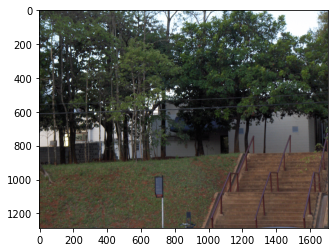

In [18]:
x=Image.open(dataset['image'][1350])
plt.imshow(x)

In [20]:
X_f = []
Y_f = []
for index, row in tqdm(dataset.iterrows()):
    X_f.append(np.array(abcd(row[0]).resize((128, 128))).flatten() / 255.0)
    Y_f.append(row[1])

1500it [09:35,  2.61it/s]


In [21]:
#converting X and Y to numpy arrays
x_casia = np.array(X_f)
y_casia = np.array(Y_f)

In [22]:
print(x_casia.shape)
print(y_casia.shape)

(1500, 49152)
(1500,)


In [23]:
x_casia = x_casia.reshape(-1, 128, 128, 3)
y_casia = to_categorical(y_casia, 2)     #y is one hot encoded

In [24]:
X_train, X_val, Y_train, Y_val = train_test_split(x_casia, y_casia, test_size = 0.2, random_state=5)

In [25]:
X_train.shape

(1200, 128, 128, 3)

In [26]:
Y_train.shape

(1200, 2)

In [27]:
X_val.shape

(300, 128, 128, 3)

In [28]:
Y_val.shape

(300, 2)

In [29]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'valid', 
                 activation ='relu', input_shape = (128,128,3)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'valid', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(2, activation = "softmax"))

In [30]:
optimizer = Adam()

In [31]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 124, 124, 32)      2432      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 120, 120, 32)      25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 60, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 60, 60, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 115200)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               29491456  
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0

In [33]:
early_stopping = EarlyStopping(monitor='val_acc',
                              min_delta=0,
                              patience=2,
                              verbose=1, mode='auto')

In [34]:
X_train.shape

(1200, 128, 128, 3)

In [35]:
history = model.fit(X_train, Y_train, batch_size = 100, epochs = 5, 
          validation_data = (X_val, Y_val), verbose = 1, callbacks=[early_stopping])

Epoch 1/5
12/12 [==============================] - 101s 8s/step - loss: 0.9713 - accuracy: 0.7817 - val_loss: 0.0066 - val_accuracy: 0.9967
Epoch 2/5
12/12 [==============================] - 101s 8s/step - loss: 0.0178 - accuracy: 0.9983 - val_loss: 4.7977e-05 - val_accuracy: 1.0000
Epoch 3/5
12/12 [==============================] - 101s 8s/step - loss: 0.0036 - accuracy: 0.9983 - val_loss: 3.3934e-07 - val_accuracy: 1.0000
Epoch 4/5
12/12 [==============================] - 101s 8s/step - loss: 5.3696e-07 - accuracy: 1.0000 - val_loss: 3.9736e-10 - val_accuracy: 1.0000
Epoch 5/5
12/12 [==============================] - 100s 8s/step - loss: 0.0011 - accuracy: 0.9992 - val_loss: 7.4704e-08 - val_accuracy: 1.0000
